# Forcing ratios calculated using Gregory regression

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from estimation import *
import xarray as xr

In [2]:
directory = '../longrunmip_data/'
#all_models = ['MPIESM12', 'MIROC32', 'IPSLCM5A', 'HadGEM2', 'HadCM3L', 'GISSE2R', 'GFDLESM2M', 'GFDLCM3', 'FAMOUS', 'ECHAM5MPIOM', 'ECEARTH', 'CNRMCM61', 'CESM104', 'CCSM3']

file_list = [ f.name for f in os.scandir(directory) if f.is_file()]
file_list_namesplits = [file.rsplit("_") for file in file_list]
file_list_namesplits[:10]
files_model_names = [file_list_namesplits[k][1] for k in range(len(file_list_namesplits))]

experiments = {'MPIESM12': ['abrupt2x', 'abrupt4x', 'abrupt8x', 'abrupt16x'],
               'HadCM3L': ['abrupt2x', 'abrupt4x', 'abrupt6x', 'abrupt8x'],
               'FAMOUS': ['abrupt2x', 'abrupt4x'],
               'CNRMCM61': ['abrupt2x', 'abrupt4x'], #but this may be a duplicate of the CMIP6 runs?
               'CESM104': ['abrupt2x', 'abrupt4x', 'abrupt8x'],
               'CCSM3': ['abrupt2x', 'abrupt4x', 'abrupt8x']
              }

model_list = list(experiments.keys())

In [3]:
list(experiments.keys())

['MPIESM12', 'HadCM3L', 'FAMOUS', 'CNRMCM61', 'CESM104', 'CCSM3']

# Studying 6 models with abrupt-2xCO2

In [4]:
reglengths = [5, 10, 20, 30]
forcing_ratio_df = pd.DataFrame([],index = model_list + ['Ensemble mean','Mean of model results'], columns = reglengths + ['Mean'])

In [5]:
forcing_ratio_df

,5,10,20,30,Mean
MPIESM12,NaN,NaN,NaN,NaN,NaN
HadCM3L,NaN,NaN,NaN,NaN,NaN
FAMOUS,NaN,NaN,NaN,NaN,NaN
CNRMCM61,NaN,NaN,NaN,NaN,NaN
CESM104,NaN,NaN,NaN,NaN,NaN
CCSM3,NaN,NaN,NaN,NaN,NaN
Ensemble mean,NaN,NaN,NaN,NaN,NaN
Mean of model results,NaN,NaN,NaN,NaN,NaN


In [6]:
def load_longrunmip_data(model, exp = 'abrupt2x', length_restriction = None):
    directory = '../longrunmip_data/'
    file_list = [ f.name for f in os.scandir(directory) if f.is_file()]
    file_list_namesplits = [file.rsplit("_") for file in file_list]
    files_model_names = [file_list_namesplits[k][1] for k in range(len(file_list_namesplits))]
    
    model_index = [i for i,x in enumerate(files_model_names) if x==model]
    model_files = [file_list[model_index[k]] for k in range(len(model_index))]
    model_exp_files = [file_list[model_index[k]] for k in range(len(model_index)) if file_list_namesplits[model_index[k]][2] == exp]
    model_exp_files.sort() # make sure tas is the last file

    ds_tas = xr.open_dataset(directory + model_exp_files[-1])
    ds_toarad = xr.open_mfdataset(directory + model_exp_files[0])
    deltaT = ds_tas.tas.values
    toarad = ds_toarad['netTOA'].values
    if length_restriction != None:
        deltaT = deltaT[:length_restriction]
        toarad = toarad[:length_restriction]
    return [deltaT, toarad]

In [7]:
tas, toarad = load_longrunmip_data('MPIESM12', length_restriction = 150)

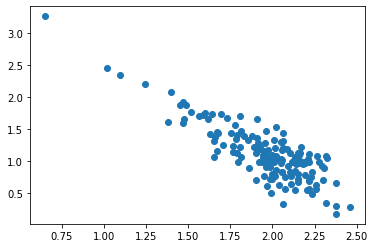

In [8]:
plt.scatter(tas,toarad)



mean forcing ratio when regressing 5 years is: 0.4567588393125065
mean forcing ratio when regressing 10 years is: 0.5018375386075823
mean forcing ratio when regressing 20 years is: 0.509862662107538
mean forcing ratio when regressing 30 years is: 0.5270632621998239


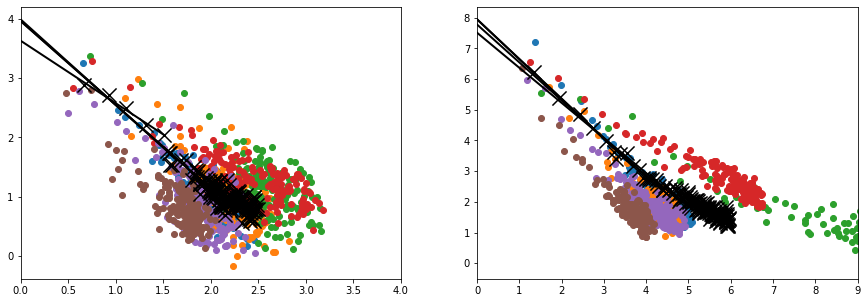

In [11]:
fig, ax = plt.subplots(ncols = 2, figsize = (15,5))

for (mm, model) in enumerate(model_list):    
    # abrupt2x
    model_tas_2x, model_toarad_2x = load_longrunmip_data(model, exp = 'abrupt2x', length_restriction = 150)
    model_df_T_2x = pd.DataFrame(model_tas_2x, columns = [model])
    model_df_N_2x = pd.DataFrame(model_toarad_2x, columns = [model])
    
    ax[0].scatter(model_tas_2x, model_toarad_2x)
    
    # abrupt4x
    model_tas_4x, model_toarad_4x = load_longrunmip_data(model, exp = 'abrupt4x', length_restriction = 150)
    model_df_T_4x = pd.DataFrame(model_tas_4x, columns = [model])
    model_df_N_4x = pd.DataFrame(model_toarad_4x, columns = [model])
    
    ax[1].scatter(model_tas_4x, model_toarad_4x)
    
    for regyears in reglengths:
        model_reg_2x = np.polyfit(model_tas_2x[:regyears], model_toarad_2x[:regyears], deg = 1)
        model_reg_4x = np.polyfit(model_tas_4x[:regyears], model_toarad_4x[:regyears], deg = 1)
        forcing_ratio = model_reg_2x[1]/model_reg_4x[1]
        #forcing_ratio = model_reg_4x[1]/model_reg_2x[1]
        
        forcing_ratio_df[regyears].loc[model] = forcing_ratio
        #if regyears == 5:
        #    forcing_ratio_list.append(forcing_ratio)
        #print(model, 'forcing ratio when regressing', regyears, 'years is:', forcing_ratio)
    forcing_ratio_df.loc[model]['Mean'] = np.nanmean(forcing_ratio_df.loc[model].values)
    
    if mm == 0: # first model
        df_T_2x = model_df_T_2x
        df_N_2x = model_df_N_2x
        df_T_4x = model_df_T_4x
        df_N_4x = model_df_N_4x
    else:
        df_T_2x = pd.concat([df_T_2x, model_df_T_2x], axis = 1, ignore_index = True)
        df_N_2x = pd.concat([df_N_2x, model_df_N_2x], axis = 1, ignore_index = True)
        df_T_4x = pd.concat([df_T_4x, model_df_T_4x], axis = 1, ignore_index = True)
        df_N_4x = pd.concat([df_N_4x, model_df_N_4x], axis = 1, ignore_index = True)
        
model_mean_T_2x = df_T_2x.mean(axis=1)
model_mean_N_2x = df_N_2x.mean(axis=1)
ax[0].scatter(model_mean_T_2x, model_mean_N_2x, marker = 'x', color = 'black', s = 200)
model_mean_T_4x = df_T_4x.mean(axis=1)
model_mean_N_4x = df_N_4x.mean(axis=1)
ax[1].scatter(model_mean_T_4x, model_mean_N_4x, marker = 'x', color = 'black', s = 200)



print('\n')
for regyears in [5, 10, 20, 30]:

    reg_2x = np.polyfit(model_mean_T_2x[:regyears], model_mean_N_2x[:regyears], deg = 1)
    T_incl0 = np.concatenate([[0], model_mean_T_2x[:regyears].values])
    linfit_2x = np.polyval(reg_2x, T_incl0)
    ax[0].plot(T_incl0, linfit_2x, color = 'black', linewidth = 2)

    reg_4x = np.polyfit(model_mean_T_4x[:regyears], model_mean_N_4x[:regyears], deg = 1)
    T_incl0 = np.concatenate([[0], model_mean_T_4x[:regyears].values])
    linfit_4x = np.polyval(reg_4x, T_incl0)
    ax[1].plot(T_incl0, linfit_4x, color = 'black', linewidth = 2)

    print('mean forcing ratio when regressing', regyears, 'years is:', reg_2x[1]/reg_4x[1])
    #print('mean forcing ratio when regressing', regyears, 'years is:', reg_4x[1]/reg_2x[1])
    forcing_ratio_df.loc['Ensemble mean'][regyears] = reg_2x[1]/reg_4x[1]
forcing_ratio_df.loc['Ensemble mean']['Mean'] = np.nanmean(forcing_ratio_df.loc['Ensemble mean'].values)

ax[0].set_xlim(0,4)
ax[1].set_xlim(0,9)

for col in forcing_ratio_df.columns:
    forcing_ratio_df.loc['Mean of model results'][col] = forcing_ratio_df.loc[model_list][col].mean()
    #forcing_ratio_df.loc['Mean of model results'][col] = forcing_ratio_df.loc[model_list][col].drop('FAMOUS').mean()
    

In [12]:
forcing_ratio_df

,5,10,20,30,Mean
MPIESM12,0.440713,0.447211,0.451553,0.460077,0.449888
HadCM3L,0.311619,0.538162,0.546384,0.518006,0.478543
FAMOUS,0.598411,0.647816,0.657607,0.670238,0.643518
CNRMCM61,0.49392,0.475968,0.484649,0.522045,0.494146
CESM104,0.377659,0.409692,0.449885,0.453987,0.422806
CCSM3,0.483946,0.488038,0.410738,0.432791,0.453878
Ensemble mean,0.456759,0.501838,0.509863,0.527063,0.498881
Mean of model results,0.451045,0.501148,0.500136,0.509524,0.490463


In [155]:
f#orcing_ratio_df.to_csv('../Other_estimates/forcing_ratios_2x_to_4x_longrunmip.csv')

<AxesSubplot:>

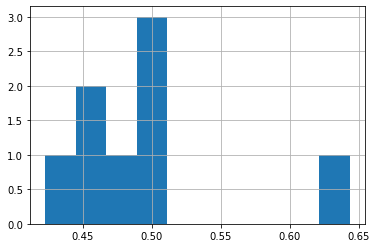

In [191]:
forcing_ratio_df['Mean'].hist()

In [192]:
forcing_ratio_df['Mean'].mean()

0.4915154206580983

In [193]:
s = forcing_ratio_df.style.format(precision=2)
s.set_table_styles([
        {'selector': 'toprule', 'props': ':hline;'},
        {'selector': 'midrule', 'props': ':hline;'},
        {'selector': 'bottomrule', 'props': ':hline;'}])
print(s.to_latex(column_format= 'lccccc'))

\begin{tabular}{lccccc}
\hline
 & 5 & 10 & 20 & 30 & Mean \\
\hline
MPIESM12 & 0.44 & 0.45 & 0.45 & 0.46 & 0.45 \\
HadCM3L & 0.31 & 0.54 & 0.55 & 0.52 & 0.48 \\
FAMOUS & 0.60 & 0.65 & 0.66 & 0.67 & 0.64 \\
CNRMCM61 & 0.49 & 0.48 & 0.48 & 0.52 & 0.49 \\
CESM104 & 0.38 & 0.41 & 0.45 & 0.45 & 0.42 \\
CCSM3 & 0.48 & 0.49 & 0.41 & 0.43 & 0.45 \\
Ensemble mean & 0.46 & 0.50 & 0.51 & 0.53 & 0.50 \\
Mean of model results & 0.45 & 0.50 & 0.50 & 0.51 & 0.49 \\
\hline
\end{tabular}



## Forcing ratio between NxCO2 and 2xCO2



mean forcing ratio when regressing 5 years is: 0.22016346068069353
mean forcing ratio when regressing 10 years is: 0.23675654995948056
mean forcing ratio when regressing 20 years is: 0.2447893882695749
mean forcing ratio when regressing 30 years is: 0.25065483560599694


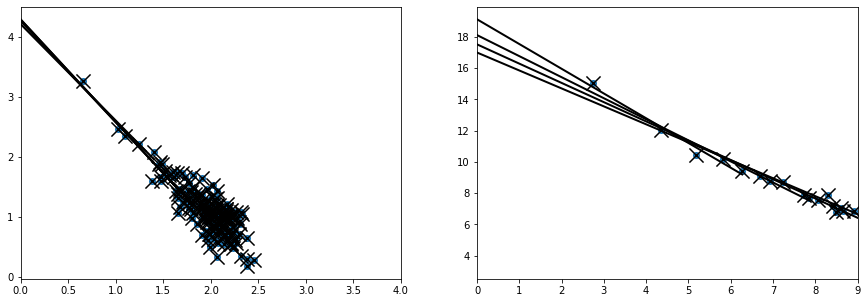

In [178]:
#model_list = ['HadCM3L'] # only one model ran 6xCO2
#model_list = ['MPIESM12', 'HadCM3L', 'CESM104', 'CCSM3'] # 8x
model_list = ['MPIESM12'] # 16x

forcing_ratio_df2 = pd.DataFrame([],index = model_list + ['Ensemble mean','Mean of model results'], columns = reglengths + ['Mean'])

fig, ax = plt.subplots(ncols = 2, figsize = (15,5))

for (mm, model) in enumerate(model_list):    
    # abrupt2x
    model_tas_2x, model_toarad_2x = load_longrunmip_data(model, exp = 'abrupt2x', length_restriction = 150)
    model_df_T_2x = pd.DataFrame(model_tas_2x, columns = [model])
    model_df_N_2x = pd.DataFrame(model_toarad_2x, columns = [model])
    
    ax[0].scatter(model_tas_2x, model_toarad_2x)
    
    # abrupt4x
    model_tas, model_toarad = load_longrunmip_data(model, exp = 'abrupt16x', length_restriction = 150)
    model_df_T = pd.DataFrame(model_tas, columns = [model])
    model_df_N = pd.DataFrame(model_toarad, columns = [model])
    
    ax[1].scatter(model_tas, model_toarad)
    
    for regyears in reglengths:
        model_reg_2x = np.polyfit(model_tas_2x[:regyears], model_toarad_2x[:regyears], deg = 1)
        model_reg = np.polyfit(model_tas[:regyears], model_toarad[:regyears], deg = 1)
        forcing_ratio = model_reg_2x[1]/model_reg[1]
        #forcing_ratio = model_reg[1]/model_reg_2x[1]
        
        forcing_ratio_df2[regyears].loc[model] = forcing_ratio
        #if regyears == 5:
        #    forcing_ratio_list.append(forcing_ratio)
        #print(model, 'forcing ratio when regressing', regyears, 'years is:', forcing_ratio)
    forcing_ratio_df2.loc[model]['Mean'] = np.nanmean(forcing_ratio_df2.loc[model].values)
    
    if mm == 0: # first model
        df_T_2x = model_df_T_2x
        df_N_2x = model_df_N_2x
        df_T = model_df_T
        df_N = model_df_N
    else:
        df_T_2x = pd.concat([df_T_2x, model_df_T_2x], axis = 1, ignore_index = True)
        df_N_2x = pd.concat([df_N_2x, model_df_N_2x], axis = 1, ignore_index = True)
        df_T = pd.concat([df_T, model_df_T], axis = 1, ignore_index = True)
        df_N = pd.concat([df_N, model_df_N], axis = 1, ignore_index = True)
        
model_mean_T_2x = df_T_2x.mean(axis=1)
model_mean_N_2x = df_N_2x.mean(axis=1)
ax[0].scatter(model_mean_T_2x, model_mean_N_2x, marker = 'x', color = 'black', s = 200)
model_mean_T = df_T.mean(axis=1)
model_mean_N = df_N.mean(axis=1)
ax[1].scatter(model_mean_T, model_mean_N, marker = 'x', color = 'black', s = 200)



print('\n')
for regyears in [5, 10, 20, 30]:

    reg_2x = np.polyfit(model_mean_T_2x[:regyears], model_mean_N_2x[:regyears], deg = 1)
    T_incl0 = np.concatenate([[0], model_mean_T_2x[:regyears].values])
    linfit_2x = np.polyval(reg_2x, T_incl0)
    ax[0].plot(T_incl0, linfit_2x, color = 'black', linewidth = 2)

    reg = np.polyfit(model_mean_T[:regyears], model_mean_N[:regyears], deg = 1)
    T_incl0 = np.concatenate([[0], model_mean_T[:regyears].values])
    linfit = np.polyval(reg, T_incl0)
    ax[1].plot(T_incl0, linfit, color = 'black', linewidth = 2)

    print('mean forcing ratio when regressing', regyears, 'years is:', reg_2x[1]/reg[1])
    #print('mean forcing ratio when regressing', regyears, 'years is:', reg[1]/reg_2x[1])
    forcing_ratio_df2.loc['Ensemble mean'][regyears] = reg_2x[1]/reg[1]
forcing_ratio_df2.loc['Ensemble mean']['Mean'] = np.nanmean(forcing_ratio_df2.loc['Ensemble mean'].values)

ax[0].set_xlim(0,4)
ax[1].set_xlim(0,9)
2
for col in forcing_ratio_df.columns:
    forcing_ratio_df2.loc['Mean of model results'][col] = forcing_ratio_df2.loc[model_list][col].mean()



In [180]:
forcing_ratio_df2

,5,10,20,30,Mean
MPIESM12,0.220163,0.236757,0.244789,0.250655,0.238091
Ensemble mean,0.220163,0.236757,0.244789,0.250655,0.238091
Mean of model results,0.220163,0.236757,0.244789,0.250655,0.238091


In [181]:
forcing_ratio_df2.to_csv('../Other_estimates/forcing_ratios_2x_to_16x.csv')

In [119]:
s2 = forcing_ratio_df2.style.format(precision=2)
s2.set_table_styles([
        {'selector': 'toprule', 'props': ':hline;'},
        {'selector': 'midrule', 'props': ':hline;'},
        {'selector': 'bottomrule', 'props': ':hline;'}])
print(s2.to_latex(column_format= 'lccccc'))

\begin{tabular}{lccccc}
\hline
 & 5 & 10 & 20 & 30 & Mean \\
\hline
CESM2 & -0.75 & -1.11 & -1.18 & -1.28 & -1.08 \\
CNRM-CM6-1 & -1.11 & -1.16 & -1.13 & -1.22 & -1.15 \\
CanESM5 & -1.06 & -1.16 & -1.11 & -1.08 & -1.10 \\
GISS-E2-1-G & -1.03 & -0.99 & -1.00 & -1.02 & -1.01 \\
IPSL-CM6A-LR & -1.53 & -1.32 & -1.40 & -1.37 & -1.41 \\
MIROC6 & -1.33 & -1.14 & -1.07 & -1.14 & -1.17 \\
MRI-ESM2-0 & -0.94 & -0.95 & -0.87 & -0.86 & -0.90 \\
TaiESM1 & -1.26 & -1.28 & -1.34 & -1.36 & -1.31 \\
HadGEM3-GC31-LL & -1.05 & -1.02 & -0.98 & -0.99 & -1.01 \\
Ensemble mean & -1.16 & -1.15 & -1.12 & -1.15 & -1.15 \\
Mean of model results & -1.12 & -1.12 & -1.12 & -1.15 & -1.13 \\
\hline
\end{tabular}



## Convert all tables to latex

In [194]:
table4x = pd.read_csv('../Other_estimates/forcing_ratios_2x_to_4x_longrunmip.csv', index_col=0)
table6x = pd.read_csv('../Other_estimates/forcing_ratios_2x_to_6x_longrunmip.csv', index_col=0)
table8x = pd.read_csv('../Other_estimates/forcing_ratios_2x_to_8x_longrunmip.csv', index_col=0)
table16x = pd.read_csv('../Other_estimates/forcing_ratios_2x_to_16x_longrunmip.csv', index_col=0)


In [196]:
for table in [table4x, table6x, table8x, table16x]:
    s2 = table.style.format(precision=2)
    s2.set_table_styles([
            {'selector': 'toprule', 'props': ':hline;'},
            {'selector': 'midrule', 'props': ':hline;'},
            {'selector': 'bottomrule', 'props': ':hline;'}])
    print(s2.to_latex(column_format= 'lccccc'))

\begin{tabular}{lccccc}
\hline
 & 5 & 10 & 20 & 30 & Mean \\
\hline
MPIESM12 & 0.44 & 0.45 & 0.45 & 0.46 & 0.45 \\
HadCM3L & 0.31 & 0.54 & 0.55 & 0.52 & 0.48 \\
FAMOUS & 0.60 & 0.65 & 0.66 & 0.67 & 0.64 \\
CNRMCM61 & 0.49 & 0.48 & 0.48 & 0.52 & 0.49 \\
CESM104 & 0.38 & 0.41 & 0.45 & 0.45 & 0.42 \\
CCSM3 & 0.48 & 0.49 & 0.41 & 0.43 & 0.45 \\
Ensemble mean & 0.46 & 0.50 & 0.51 & 0.53 & 0.50 \\
Mean of model results & 0.45 & 0.50 & 0.50 & 0.51 & 0.49 \\
\hline
\end{tabular}

\begin{tabular}{lccccc}
\hline
 & 5 & 10 & 20 & 30 & Mean \\
\hline
HadCM3L & 0.22 & 0.41 & 0.40 & 0.38 & 0.35 \\
Ensemble mean & 0.22 & 0.41 & 0.40 & 0.38 & 0.35 \\
Mean of model results & 0.22 & 0.41 & 0.40 & 0.38 & 0.35 \\
\hline
\end{tabular}

\begin{tabular}{lccccc}
\hline
 & 5 & 10 & 20 & 30 & Mean \\
\hline
MPIESM12 & 0.30 & 0.32 & 0.33 & 0.33 & 0.32 \\
HadCM3L & 0.22 & 0.41 & 0.40 & 0.38 & 0.35 \\
CESM104 & 0.23 & 0.26 & 0.27 & 0.27 & 0.26 \\
CCSM3 & 0.29 & 0.30 & 0.26 & 0.26 & 0.28 \\
Ensemble mean & 0.26 & 0